In [1]:
import os
os.environ['OMP_NUM_THREADS']='2'
os.environ['LD_LIBRARY_PATH']=''
os.environ['CUDA_LAUNCH_BLOCKING']='1'

In [2]:
%cd /home/pengyu.zhang/project/superres/ProbSR/Experiment2

/home/pengyu.zhang/project/superres/ProbSR/Experiment2


In [3]:
from data_generation import *
from scipy.linalg import sqrtm
from downscaling import *
import cv2
import torchvision.transforms as T
import torch.nn.functional as F
import time

## Bicubic interpolation downscale

### Upscale by 4

In [4]:
N_low = 40
N_high = 160
scale = 4
a, b, c, d = -2.5,-2.5,1,0

h_low = 1/(N_low-1)
x_low = np.arange(0,1.0001,h_low)
y_low = np.arange(0,1.0001,h_low)

h_high = 1/(N_high-1)
x_high = np.arange(0,1.0001,h_high)
y_high = np.arange(0,1.0001,h_high)

In [5]:
w_low, r_low, A_low, x_low, y_low = generate_data(N_low,a,b,c,d)
w_high, r_high, A_high, x_high, y_high = generate_data(N_high,a,b,c,d)

In [17]:
start = time.time()
u = linalg.spsolve(A_high,r_high)
end = time.time()
print(end-start)

0.08127355575561523


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters for prior variance
prior_sigma = 0.002
ll_sigma = 0.001

In [7]:
A_high = csr_matrix(A_high)

In [8]:
operator = (A_high.T) * (1/prior_sigma**2)
b_high = create_forcing_term(N_high,a,b,c,d)

In [19]:
# Parameters for Langevin dynamics
K = 40
s = 0.0004

x = torch.tensor(w_low).to(torch.float32)
# posterior_initial = torch.randn(*[N_high,N_high]).to(torch.float32)
# z = posterior_initial
chains_evolution = []

startTime = time.time()
z = F.interpolate(x.reshape(1,1,N_low,N_low),(N_high,N_high),mode='bicubic').reshape(N_high,N_high)
z = z.clone().detach().requires_grad_(True)

for i in range(K):
    # Grad log-likelihood
    x_hat = F.interpolate(z.reshape(1,1,N_high,N_high),(N_low,N_low),mode='bicubic').reshape(N_low,N_low)
    log_likelihood = (-1/(2*math.pow(ll_sigma, 2)) * torch.matmul((x-x_hat).reshape(1,N_low**2),(x-x_hat).reshape(N_low**2,1)))
    grad_ll = torch.autograd.grad(log_likelihood, z)[0]

    # startTime = time.time()
    # Grad prior
    difference = A_high.dot(z.cpu().data.numpy().reshape(N_high*N_high,1)) - b_high.reshape(N_high**2,1)
    # log_prior = - 0.5 * difference.T @ G_inverse @ difference
    # grad_log_prior = torch.autograd.grad(log_prior, z)[0]
    grad_log_prior = (- operator.dot(difference)).reshape(N_high,N_high)
    grad_log_prior = torch.tensor(grad_log_prior).to(torch.float32)
    #endTime = time.time()
    #print(endTime-startTime)
    # grad_log_likelihood = torch.matmul(G,grad_ll.reshape(N_high**2,1)).reshape(N_high,N_high)
    
    # Random noise term
    W = torch.randn(*[N_high,N_high])
    # random = torch.matmul(G_sqrt,W.reshape(N_high**2,1)).reshape(N_high,N_high)
    
    z = z + 0.5 * s ** 2 * grad_log_prior + 0.5 * s ** 2 * grad_ll + s * W
    # chains_evolution.append(z.cpu().data.numpy())  
endTime = time.time()
print(endTime-startTime) 

0.02234506607055664


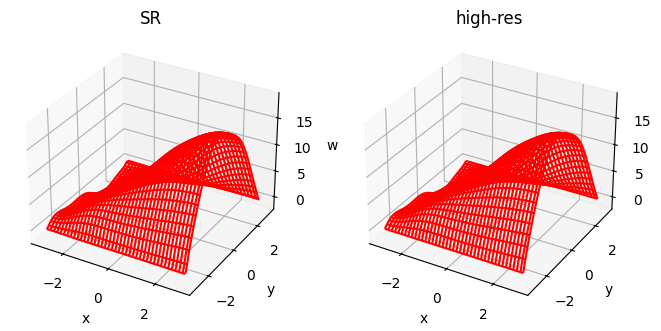

In [14]:
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(121, projection='3d')
X, Y = np.meshgrid(x_high, y_high)
ax1.plot_wireframe(X, Y, z.cpu().data.numpy(),color='r')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('w')
ax1.set_title('SR')
ax2 = fig.add_subplot(122, projection='3d')
X, Y = np.meshgrid(x_high,y_high)
ax2.plot_wireframe(X, Y, w_high,color='r')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('w')
ax2.set_title('high-res')
plt.show()

In [15]:
# z = F.interpolate(x.reshape(1,1,N_low,N_low),(N_high,N_high),mode='bicubic').reshape(N_high,N_high)

In [16]:
error1 = abs(w_high - z.cpu().data.numpy())
print('SR L2 Error:', (error1**2).sum()/error1.shape[0]**2)

SR L2 Error: 0.04545329158078318


In [ ]:
# G = ResidualLearning().to(device)
G = U_net(1,1).to(device)
# G.load_state_dict(torch.load('/home/pengyu.zhang/project/superres/ProbSR/Experiment2/Bicubic_Downsampling/models/model3/40_160/lr0.01_gamma0.5_stepsize100_K60_llsigma_0.001_psigma_0.002/ckpt/current_epoch.pth')['netG'])
G.load_state_dict(torch.load('/home/pengyu.zhang/project/superres/ProbSR/Experiment2/Bicubic_Downsampling/models/model3/40_160/lr0.001_gamma0.5_stepsize100_K200_llsigma_0.004_psigma_0.002/ckpt/current_epoch.pth')['netG'])

In [19]:
import random
total_error1 = 0
total_error2 = 0
for i in tqdm(range(30)):
    a = random.uniform(-4,4)
    b = random.uniform(-3,3)
    c = random.uniform(0,3)
    d = random.uniform(-2,2)
    w_low, r_low, A_low, x_low, y_low = generate_data(N_low,a,b,c,d)
    w_high, r_high, A_high, x_high, y_high = generate_data(N_high,a,b,c,d)
    b_high = create_forcing_term(N_high,a,b,c,d)

    # Parameters for Langevin dynamics
    K = 60
    s = 0.0004

    x = torch.tensor(w_low).to(torch.float32)
    z = F.interpolate(x.reshape(1,1,N_low,N_low),(N_high,N_high)).reshape(N_high,N_high)
    z = z.clone().detach().requires_grad_(True)

    for i in range(K):
        # Grad log-likelihood
        x_hat = F.interpolate(z.reshape(1,1,N_high,N_high),(N_low,N_low)).reshape(N_low,N_low)
        log_likelihood = (-1/(2*math.pow(ll_sigma, 2)) * torch.matmul((x-x_hat).reshape(1,N_low**2),(x-x_hat).reshape(N_low**2,1)))
        grad_ll = torch.autograd.grad(log_likelihood, z)[0]

        # startTime = time.time()
        # Grad prior
        difference = A_high.dot(z.cpu().data.numpy().reshape(N_high*N_high,1)) - b_high.reshape(N_high**2,1)
        # log_prior = - 0.5 * difference.T @ G_inverse @ difference
        # grad_log_prior = torch.autograd.grad(log_prior, z)[0]
        grad_log_prior = (- operator.dot(difference)).reshape(N_high,N_high)
        grad_log_prior = torch.tensor(grad_log_prior).to(torch.float32)
        #endTime = time.time()
        #print(endTime-startTime)
        # grad_log_likelihood = torch.matmul(G,grad_ll.reshape(N_high**2,1)).reshape(N_high,N_high)
        
        # Random noise term
        W = torch.randn(*[N_high,N_high])
        # random = torch.matmul(G_sqrt,W.reshape(N_high**2,1)).reshape(N_high,N_high)
        
        z = z + 0.5 * s ** 2 * grad_log_prior + 0.5 * s ** 2 * grad_ll + s * W

    error1 = abs(w_high - z.cpu().data.numpy())
    total_error1 += (error1**2).sum()/error1.shape[0]**2


    x = torch.tensor(w_low).to(torch.float32).to(device)
    z = F.interpolate(x.reshape(1,1,N_low,N_low),(N_high,N_high)).reshape(N_high,N_high)
    z = z.clone().detach().requires_grad_(True)

    for i in range(K):
        # Grad log-likelihood
        # observation = torch.spmm(H,z.reshape(N_high*N_high,1)).reshape(N_low,N_low)
        downscaled = F.interpolate(z.reshape(1,1,N_high,N_high),(N_low,N_low)).reshape(N_low,N_low)
        x_hat = downscaled + G(downscaled.reshape(1,1,N_low,N_low)).reshape(N_low,N_low)
        log_likelihood = (-1/(2*math.pow(ll_sigma, 2)) * torch.matmul((x-x_hat).reshape(1,N_low**2),(x-x_hat).reshape(N_low**2,1)))
        grad_ll = torch.autograd.grad(log_likelihood, z)[0]
        # grad_log_likelihood = torch.matmul(G,grad_ll.reshape(N_high**2,1)).reshape(N_high,N_high)
        
        # Grad prior
        difference = A_high.dot(z.cpu().data.numpy().reshape(N_high*N_high,1)) - b_high.reshape(N_high**2,1)
        # log_prior = - 0.5 * difference.T @ G_inverse @ difference
        # grad_log_prior = torch.autograd.grad(log_prior, z)[0]
        grad_log_prior = (- operator.dot(difference)).reshape(N_high,N_high)
        grad_log_prior = torch.tensor(grad_log_prior).to(torch.float32).to(device)
        
        # Random noise term
        W = torch.randn(*[N_high,N_high]).to(device)
        # random = torch.matmul(G_sqrt,W.reshape(N_high**2,1)).reshape(N_high,N_high)
        
        z = z + 0.5 * s ** 2 * grad_log_prior + 0.5 * s ** 2 * grad_ll + s * W
        # chains_evolution.append(z.cpu().data.numpy())  

    error2 = abs(w_high - z.cpu().data.numpy())
    total_error2 += (error2**2).sum()/error2.shape[0]**2


print(total_error1,total_error2)

100%|██████████| 30/30 [02:59<00:00,  5.98s/it]

4.069130296275549 5.301251766864019


### Upscale by 6

In [5]:
N_low = 21
N_high = 121
scale = 6
a, b, c = 8,5,5

h_low = 1/(N_low-1)
x_low = np.arange(0,1.0001,h_low)
y_low = np.arange(0,1.0001,h_low)

h_high = 1/(N_high-1)
x_high = np.arange(0,1.0001,h_high)
y_high = np.arange(0,1.0001,h_high)

In [82]:
w_low, r_low, A_low, x_low, y_low = generate_data(N_low,a,b,c)
w_high, r_high, A_high, x_high, y_high = generate_data(N_high,a,b,c)

In [97]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters for prior variance
prior_sigma = 0.002
ll_sigma = 0.003

In [98]:
# Defind covariance matrix
G = np.eye(N_high**2) * prior_sigma**2
G_inverse = np.eye(N_high**2) * (1/prior_sigma**2)

# Turn matrices to tensors
G = torch.tensor(G).to(torch.float32)
G_inverse = torch.tensor(G_inverse).to(torch.float32)
A_high = torch.tensor(create_A(N_high)).to(torch.float32)
b_high = torch.tensor(create_forcing_term(N_high,a,b,c)).to(torch.float32)

# Store sparse matrices as sparse tensor
A_high = A_high.to_sparse()
G = G.to_sparse()
G_inverse = G_inverse.to_sparse()
operator = torch.spmm(A_high.T,G_inverse)

In [ ]:
# Parameters for Langevin dynamics
K = 10000
s = 0.0004

x = torch.tensor(w_low).to(torch.float32)
posterior_initial = torch.randn(*[N_high,N_high]).to(torch.float32)
z = posterior_initial
chains_evolution = []
z = z.clone().detach().requires_grad_(True)

for i in range(K):
    # Grad log-likelihood
    x_hat = F.interpolate(z.reshape(1,1,N_high,N_high),(N_low,N_low)).reshape(N_low,N_low)
    log_likelihood = (-1/(2*math.pow(ll_sigma, 2)) * torch.matmul((x-x_hat).reshape(1,N_low**2),(x-x_hat).reshape(N_low**2,1)))
    grad_ll = torch.autograd.grad(log_likelihood, z)[0]
    # grad_log_likelihood = torch.matmul(G,grad_ll.reshape(N_high**2,1)).reshape(N_high,N_high)
    
    # Grad prior
    difference = torch.spmm(A_high,z.reshape(N_high*N_high,1)) - b_high.reshape(N_high**2,1)
    # log_prior = - 0.5 * difference.T @ G_inverse @ difference
    # grad_log_prior = torch.autograd.grad(log_prior, z)[0]
    grad_log_prior = (- torch.spmm(operator,difference)).reshape(N_high,N_high)
    
    # Random noise term
    W = torch.randn(*[N_high,N_high])
    # random = torch.matmul(G_sqrt,W.reshape(N_high**2,1)).reshape(N_high,N_high)
    
    z = z + 0.5 * s ** 2 * grad_log_prior + 0.5 * s ** 2 * grad_ll + s * W
    # chains_evolution.append(z.cpu().data.numpy())   

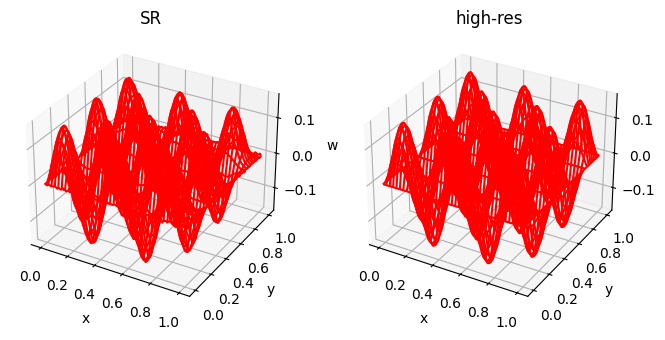

In [100]:
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(121, projection='3d')
X, Y = np.meshgrid(x_high, y_high)
ax1.plot_wireframe(X, Y, z.cpu().data.numpy(),color='r')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('w')
ax1.set_title('SR')
ax2 = fig.add_subplot(122, projection='3d')
X, Y = np.meshgrid(x_high,y_high)
ax2.plot_wireframe(X, Y, w_high,color='r')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('w')
ax2.set_title('high-res')
plt.show()

In [101]:
error1 = abs(w_high - z.cpu().data.numpy())
print('SR L2 Error:', (error1**2).sum()/error1.shape[0]**2)

SR L2 Error: 0.001568260271551795


In [ ]:
# Tamed-ULA 

# Parameters for Langevin dynamics
K = 800
s = 0.0004

x = torch.tensor(w_low).to(torch.float32)
posterior_initial = torch.randn(*[N_high,N_high]).to(torch.float32)
z = posterior_initial
chains_evolution = []
z = z.clone().detach().requires_grad_(True)

for i in range(2000):
    # Grad log-likelihood
    x_hat = F.interpolate(z.reshape(1,1,N_high,N_high),(N_low,N_low)).reshape(N_low,N_low)
    log_likelihood = (-1/(2*math.pow(ll_sigma, 2)) * torch.matmul((x-x_hat).reshape(1,N_low**2),(x-x_hat).reshape(N_low**2,1)))
    grad_ll = torch.autograd.grad(log_likelihood, z)[0]
    # grad_log_likelihood = torch.matmul(G,grad_ll.reshape(N_high**2,1)).reshape(N_high,N_high)
    
    # Grad prior
    difference = torch.spmm(A_high,z.reshape(N_high*N_high,1)) - b_high.reshape(N_high**2,1)
    grad_log_prior = (- torch.spmm(operator,difference)).reshape(N_high,N_high)
    
    grad = grad_ll + grad_log_prior
    
    # Random noise term
    W = torch.randn(*[N_high,N_high])
    # random = torch.matmul(G_sqrt,W.reshape(N_high**2,1)).reshape(N_high,N_high)
    
    z = z + 0.5 * s ** 2 * grad / (1 + 0.5 * s ** 2 * torch.norm(grad)) + s * W
    # chains_evolution.append(z.cpu().data.numpy())   